This script generates the plots to compare SCITE-RNA, DENDRO and SClineager on simulated datasets with a variable number of ground truth clones. Additionally, it plots a comparison of the runtimes.

In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import os
import json

from src_python.cell_tree import CellTree

In [2]:
def create_genotype_matrix(not_selected_genotypes, selected, gt1, gt2, mutation_matrix):
    n_cells = mutation_matrix.shape[1]
    n_loci = len(selected) + len(not_selected_genotypes)
    genotype_matrix = np.full((n_loci, n_cells),"", dtype="str")
    not_selected = [i for i in range(n_loci) if i not in selected]
    # those not selected have a gt independent of the tree learning
    for n, locus in enumerate(not_selected):
        genotype_matrix[locus] = [not_selected_genotypes[n] for _ in range(n_cells)]
    # these are the genes selected for the tree learning
    for n, locus in enumerate(selected):
        genotype_matrix[locus] = np.where(mutation_matrix[n] == 0, gt1[n], np.where(mutation_matrix[n] == 1, gt2[n], mutation_matrix[n]))
    return genotype_matrix

def create_mutation_matrix(parent_vector, mutation_indices, ct):
    n_cells = len(parent_vector)
    n_leaves = int((n_cells+1)/2)
    n_mutations = len(mutation_indices)

    # Initialize mutation matrix with zeros
    mutation_matrix = np.zeros((n_cells, n_mutations), dtype=int)

    # Mark cells with mutations
    for mutation_idx, cell_idx in enumerate(mutation_indices):
        children = [c for c in ct.dfs(cell_idx)]
        for cell in children:  # Traverse all cells below the mutation cell
            mutation_matrix[cell, mutation_idx] = 1  # Mark cells with the mutation

    return mutation_matrix[:n_leaves].T

In [3]:
path = "../data/simulated_data"

n_cells = [100, 100, 50]
n_mut = [50, 100, 100]
n_tests = 100
clones = ["5", "10", "20", ""]
stratified = ""  # "_stratified" # stratified means all clones are about equally large

use_summary_statistics = False #True # Uses the summary files saved in the data/ directory. If raw output files were generated, set to False

In [4]:
genotype_differences = {}
genotype_differences["SCITE-RNA"] = {}

if use_summary_statistics == False:
    for n_c, n_m in zip(n_cells, n_mut):
        genotype_differences["SCITE-RNA"][f"{n_c}_{n_m}"] = {}
        for clone in clones:
            differences = []
            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}{stratified}")
                genotype_pred_path = os.path.join(base_path, "sciterna_genotype", f"sciterna_genotype_{t}.txt")
                genotype_path = os.path.join(base_path, "genotype", f"genotype_{t}.txt")
                ref_path = os.path.join(base_path, "ref", f"ref_{t}.txt")
                alt_path = os.path.join(base_path, "alt", f"alt_{t}.txt")
        
                if not os.path.exists(genotype_pred_path):
                    os.makedirs(os.path.join(base_path, "sciterna_genotype"), exist_ok=True)
                    not_selected_path = os.path.join(base_path, "sciterna_not_selected_genotypes", f"sciterna_not_selected_genotypes_{t}.txt")
                    selected_path = os.path.join(base_path, "sciterna_selected_loci", f"sciterna_selected_loci_{t}.txt")
                    genotypes_path = os.path.join(base_path, "sciterna_inferred_mut_types", f"sciterna_inferred_mut_types_{t}.txt")
                    mut_loc_path = os.path.join(base_path, "sciterna_mut_loc", f"sciterna_mut_loc_{t}.txt")
                    parent_path = os.path.join(base_path, "sciterna_parent_vec", f"sciterna_parent_vec_{t}.txt")
                    
                    if os.path.getsize(not_selected_path) > 0:
                        not_selected_genotypes = np.loadtxt(not_selected_path, dtype=str)
                    else:
                        not_selected_genotypes = np.array([])
        
                    selected = np.loadtxt(selected_path, dtype=int)
                    genotypes = np.loadtxt(genotypes_path, dtype=str)
                    mutation_loc = np.loadtxt(mut_loc_path, dtype=int)
                    sciterna_parent_vec = np.loadtxt(parent_path, dtype=int)
                    gt1 = genotypes[0]
                    gt2 = genotypes[1]
                    
                    ct = CellTree(n_c)
                    ct.use_parent_vec(sciterna_parent_vec)
                    ct.mut_loc = mutation_loc
                    
                    mutation_matrix = create_mutation_matrix(ct.parent_vec, ct.mut_loc, ct)
                    genotype = create_genotype_matrix(not_selected_genotypes, selected, gt1, gt2, mutation_matrix)
                    np.savetxt(genotype_pred_path, genotype, fmt='%s')
                
                genotype_pred = np.loadtxt(genotype_pred_path, dtype=str)
                gt = np.loadtxt(genotype_path, dtype=str)
                alt = np.loadtxt(alt_path)
                ref = np.loadtxt(ref_path)
                
                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_predicted = vectorized_map(genotype_pred)
                genotype = vectorized_map(gt)
                            
                # difference = np.sum(genotype_predicted != genotype)
                difference = np.sum(np.abs(genotype_predicted - genotype))
                differences.append(difference/(n_c * n_m))
    
            genotype_differences["SCITE-RNA"][f"{n_c}_{n_m}"][clone] = differences        
            print(np.mean(differences), " mean abs difference of vafs predicted")

0.013426  mean abs difference of vafs predicted
0.011416000000000003  mean abs difference of vafs predicted
0.009476000000000002  mean abs difference of vafs predicted
0.013327  mean abs difference of vafs predicted
0.009516000000000002  mean abs difference of vafs predicted
0.008071  mean abs difference of vafs predicted
0.006736499999999999  mean abs difference of vafs predicted
0.008520999999999999  mean abs difference of vafs predicted
0.011262  mean abs difference of vafs predicted
0.009399999999999999  mean abs difference of vafs predicted
0.008001000000000001  mean abs difference of vafs predicted
0.010427000000000002  mean abs difference of vafs predicted


In [5]:
genotype_differences["SClineager"] = {}

if use_summary_statistics == False:
    for n_c, n_m in zip(n_cells, n_mut):
        genotype_differences["SClineager"][f"{n_c}_{n_m}"] = {}
        for clone in clones:
            differences = []
            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}{stratified}")
                vaf_pred_path = os.path.join(base_path, "sclineager_vaf", f"sclineager_vaf_{t}.txt")
                genotype_path = os.path.join(base_path, "genotype", f"genotype_{t}.txt")
                ref_path = os.path.join(base_path, "ref", f"ref_{t}.txt")
                alt_path = os.path.join(base_path, "alt", f"alt_{t}.txt")
        
                vaf_pred = np.loadtxt(vaf_pred_path, dtype=float)
                gt = np.loadtxt(genotype_path, dtype=str)
                alt = np.loadtxt(alt_path)
                ref = np.loadtxt(ref_path)
                
                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype = vectorized_map(gt)
                
                vaf_pred = np.round(vaf_pred * 2) / 2
                difference = np.sum(np.abs(vaf_pred - genotype))
                differences.append(difference/(n_c * n_m))
    
                    
            genotype_differences["SClineager"][f"{n_c}_{n_m}"][clone] = differences        
            print(np.mean(differences), " mean abs difference of vafs predicted")

0.025631000000000004  mean abs difference of vafs predicted
0.031489  mean abs difference of vafs predicted
0.032997  mean abs difference of vafs predicted
0.024017000000000004  mean abs difference of vafs predicted
0.024220500000000006  mean abs difference of vafs predicted
0.028336000000000007  mean abs difference of vafs predicted
0.030038999999999996  mean abs difference of vafs predicted
0.023035999999999997  mean abs difference of vafs predicted
0.031245999999999996  mean abs difference of vafs predicted
0.034899  mean abs difference of vafs predicted
0.038454  mean abs difference of vafs predicted
0.029854  mean abs difference of vafs predicted


In [12]:
genotype_differences["DENDRO"] = {}

if use_summary_statistics == False:
    for n_c, n_m in zip(n_cells, n_mut):
        genotype_differences["DENDRO"][f"{n_c}_{n_m}"] = {}
        for clone in clones:
            differences = []
            for t in range(n_tests):
                base_path = os.path.join(path, f"{n_c}c{n_m}m{clone}{stratified}")
                clones_pred_path = os.path.join(base_path, "dendro_clones", f"dendro_clones_{t}.txt")
                clones_pred = np.loadtxt(clones_pred_path, dtype=float)
                genotype_path = os.path.join(base_path, "genotype", f"genotype_{t}.txt")
                ref_path = os.path.join(base_path, "ref", f"ref_{t}.txt")
                alt_path = os.path.join(base_path, "alt", f"alt_{t}.txt")
        
                gt = np.loadtxt(genotype_path, dtype=str)
                alt = np.loadtxt(alt_path)
                ref = np.loadtxt(ref_path)
                with np.errstate(invalid='ignore'):
                    vaf_observed = alt/(alt+ref)
                
                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype = vectorized_map(gt)
                
                unique_classes = np.unique(clones_pred)
        
                # For each unique class, replace column values with the mean of the columns of that class
                for cls in unique_classes:
                    class_indices = np.where(clones_pred == cls)[0]
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", category=RuntimeWarning)
                        mean_values = np.nanmean(vaf_observed[:, class_indices], axis=1)
                    
                    # in case the mean is nan replace it with the mean genotype over all cells
                    row_nanmean = np.nanmean(vaf_observed, axis=1)
                    if np.isnan(row_nanmean).any():
                        raise ValueError("Error: The array contains NaN values.")
                    mean_values = np.where(np.isnan(mean_values), row_nanmean, mean_values)
                    if np.isnan(mean_values).any():
                        raise ValueError("Error: The array contains NaN values.")
                    
                    vaf_observed[:, class_indices] = np.tile(mean_values[:, np.newaxis], len(class_indices))
                        
                    
                vaf_observed_rounded = np.round(vaf_observed * 2) / 2
                if np.isnan(vaf_observed_rounded).any():
                    print("Error: The array contains NaN values.")
                
                difference = np.nansum(np.abs(vaf_observed_rounded - genotype))
                differences.append(difference/(n_c * n_m))
                    
            genotype_differences["DENDRO"][f"{n_c}_{n_m}"][clone] = differences           
            print(np.mean(differences), " mean abs difference of vafs predicted")

0.018368999999999996  mean abs difference of vafs predicted
0.035682  mean abs difference of vafs predicted
0.049097999999999996  mean abs difference of vafs predicted
0.05063499999999999  mean abs difference of vafs predicted
0.010152  mean abs difference of vafs predicted
0.025730500000000003  mean abs difference of vafs predicted
0.040061  mean abs difference of vafs predicted
Error: The array contains NaN values.
0.059968  mean abs difference of vafs predicted
0.017352  mean abs difference of vafs predicted
0.039131000000000006  mean abs difference of vafs predicted
0.057800000000000004  mean abs difference of vafs predicted
0.07045900000000001  mean abs difference of vafs predicted


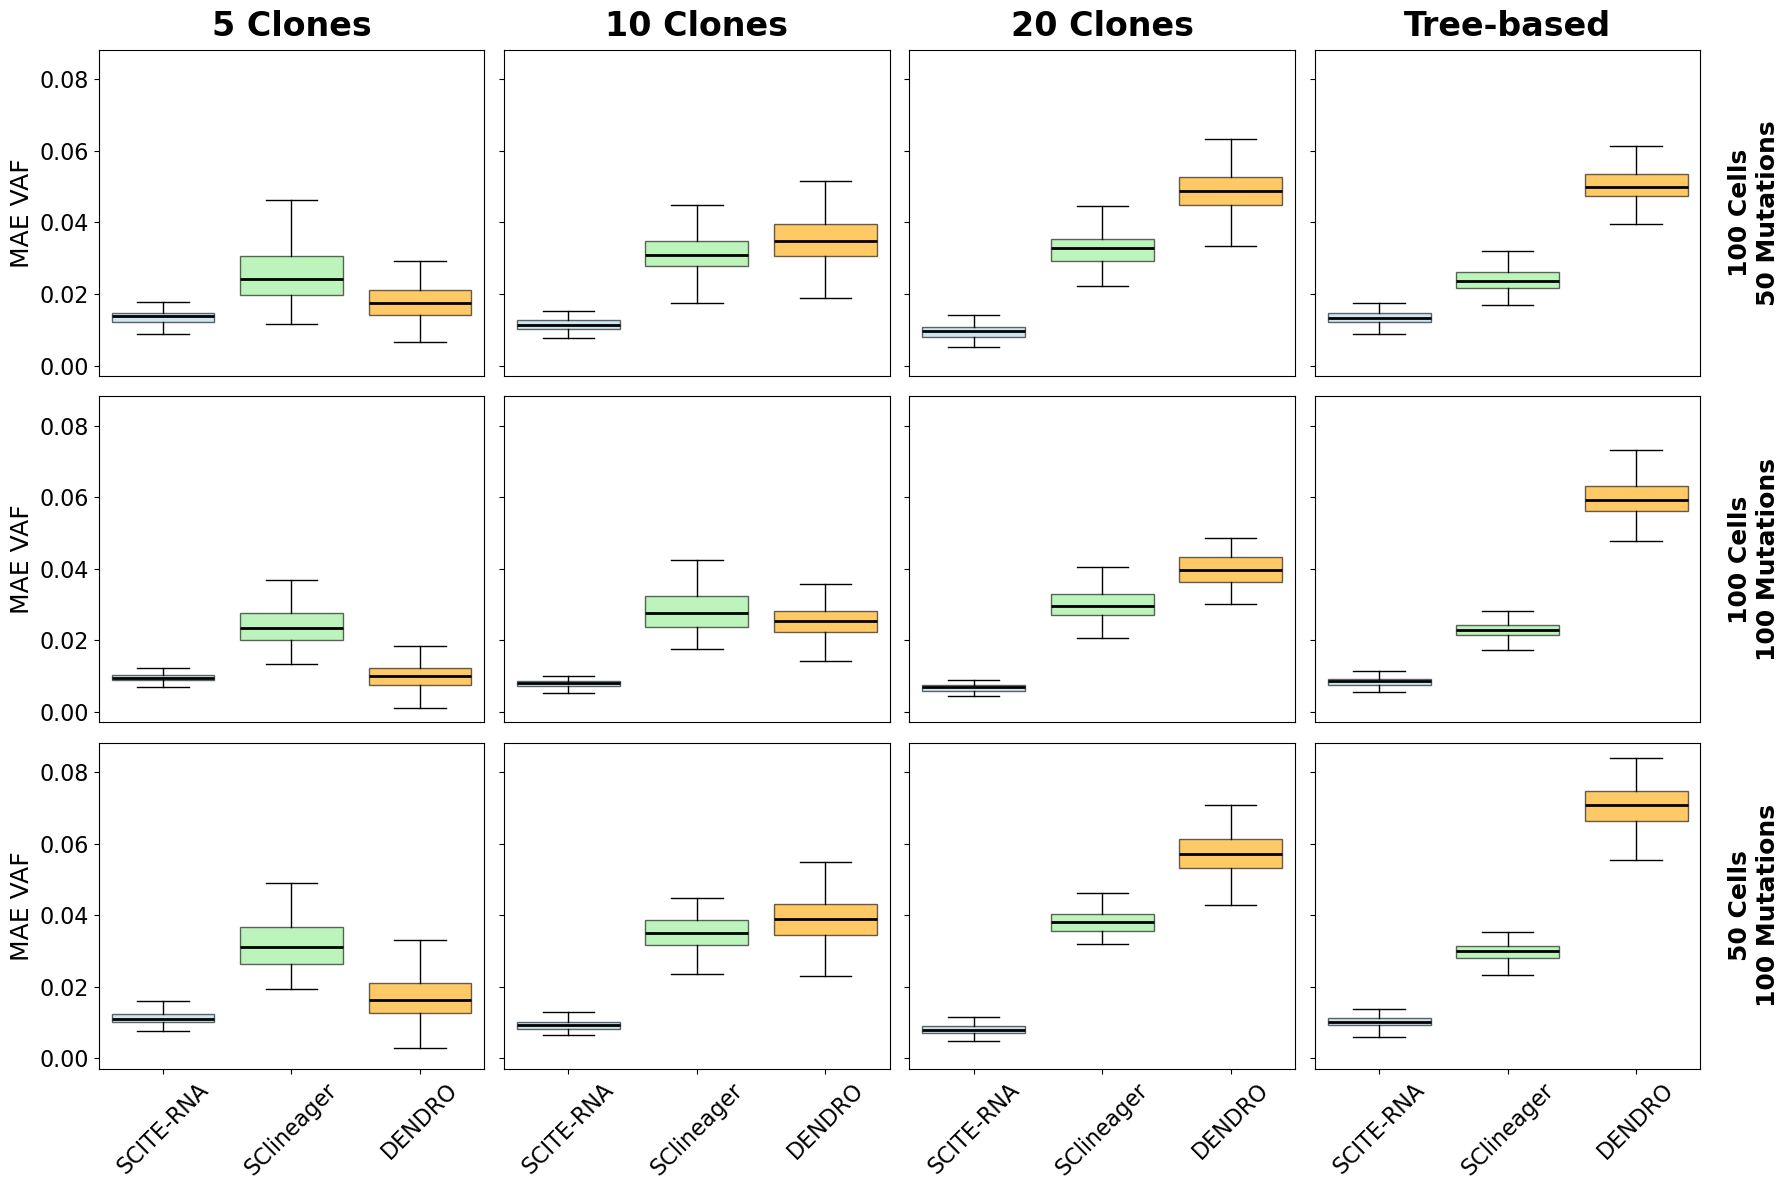

In [13]:
if use_summary_statistics:
    with open(r"../data/simulated_data/model_comparison.json") as f:
        genotype_differences = json.load(f)

models = ["SCITE-RNA", "SClineager", "DENDRO"]

fig, axes = plt.subplots(3, 4, figsize=(18, 12), sharey=True)

colors = ["lightblue", "lightgreen", "orange"]
alpha_value = 0.6

title_size = 24
label_size = 18
tick_size = 16
box_width = 2.0
boxplot_widths = 0.8

for row_idx, (n_c, n_m) in enumerate(zip(n_cells, n_mut)):
    for col_idx, clone in enumerate(clones):
        all_samples = []
        for model in models:
            all_samples.append(genotype_differences[model][f"{n_c}_{n_m}"][clone])
        
        ax = axes[row_idx, col_idx]
        box = ax.boxplot(all_samples, patch_artist=True, widths=boxplot_widths, showfliers=False)
        
        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(alpha_value)
        
        for line in box['medians']:
            line.set_linewidth(box_width)
            line.set_color("black")
        
        if row_idx == 0:
            if clone == "":
                ax.set_title("Tree-based", fontsize=title_size, pad=10, fontweight="bold")
            else:
                ax.set_title(f"{clone} Clones", fontsize=title_size, pad=10, fontweight="bold")

        if row_idx == 2:
            ax.set_xticklabels(models, fontsize=tick_size)
        else:
            ax.set_xticks([])  # Remove x-ticks for the higher rows

        if col_idx == 0:
            ax.set_ylabel('MAE VAF', fontsize=label_size)
        if col_idx == 3:
            ax.yaxis.set_label_position("right")
            ax.set_ylabel(f'{n_c} Cells\n{n_m} Mutations', fontsize=label_size, rotation=90, labelpad=20, fontproperties=FontProperties(weight='bold'))

        ax.tick_params(axis='x', labelsize=tick_size, rotation=45)
        ax.tick_params(axis='y', labelsize=tick_size)
        ax.grid(False)

plt.tight_layout()
plt.savefig("../data/results/figures/clones.png")
plt.show()

In [8]:
base_path = os.path.join(path, f"{100}c{100}m{10}{stratified}")

runtime_sclineager = np.loadtxt(os.path.join(base_path, "execution_times_sclineager.txt"))
runtime_dendro = np.loadtxt(os.path.join(base_path, "execution_times_dendro.txt"))
runtime_sciterna = np.loadtxt(os.path.join(base_path, "execution_times_sciterna.txt"))

data = [runtime_sciterna, runtime_sclineager, runtime_dendro]

plt.figure(figsize=(8, 5))
box = plt.boxplot(data, patch_artist=True, widths=boxplot_widths, showfliers=False)

colors = ["lightblue", "lightgreen", "orange"]
alpha_value = 0.6
box_width = 2.0

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(alpha_value)

for line in box['medians']:
    line.set_linewidth(box_width)
    line.set_color("black")

plt.title("Runtime Comparison (100 Cells, 100 Mutations)", fontsize=24, pad=20)
plt.ylabel('Runtime in seconds (log-scale)', fontsize=18)
plt.yscale('log')
plt.xticks(ticks=[1, 2, 3], labels=models, fontsize=18)  
plt.tick_params(axis='y', labelsize=16)
plt.grid(False)

plt.tight_layout()
# plt.savefig("../data/results/figures/runtimes.png")
plt.show()

FileNotFoundError: ../data/simulated_data\100c100m10\execution_times_sclineager.txt not found.

In [ ]:
base_path = os.path.join(path, f"{100}c{100}m{5}{stratified}")
base_path2 = os.path.join(r"../data/simulated_data - Kopie (3)", f"{100}c{100}m{5}{stratified}")

In [ ]:
# Function to compare two text files loaded as numpy arrays
def compare_files(file1, file2):
    """Compares the contents of two text files (loaded as numpy arrays)."""
    try:
        # Load the files with np.genfromtxt (handles mixed types)
        data1 = np.genfromtxt(file1, dtype=None, encoding=None)
        data2 = np.genfromtxt(file2, dtype=None, encoding=None)
        
        # Check if the data arrays are identical
        return np.array_equal(data1, data2)
    except Exception as e:
        print(f"Error comparing files {file1} and {file2}: {e}")
        return False

# Iterate through subfolders in base_path
for subfolder in os.listdir(base_path):
    subfolder_path = os.path.join(base_path, subfolder)
    subfolder_path2 = os.path.join(base_path2, subfolder)
    
    # Check if both subfolders exist in both locations
    if os.path.isdir(subfolder_path) and os.path.isdir(subfolder_path2):
        # Iterate through .txt files in the subfolder
        for filename in os.listdir(subfolder_path):
            if filename.endswith(".txt"):
                file1 = os.path.join(subfolder_path, filename)
                file2 = os.path.join(subfolder_path2, filename)

                # Check if the files exist in both subfolders
                if os.path.isfile(file1) and os.path.isfile(file2):
                    # Compare the files
                    if compare_files(file1, file2):
                        continue
                        # print(f"Files {file1} and {file2} are identical.")
                    else:
                        print(f"Files {file1} and {file2} are different.")
                else:
                    print(f"File missing in one of the subfolders: {file1}, {file2}")
    else:
        print(f"Subfolder {subfolder} not found in both directories: {subfolder_path}, {subfolder_path2}")

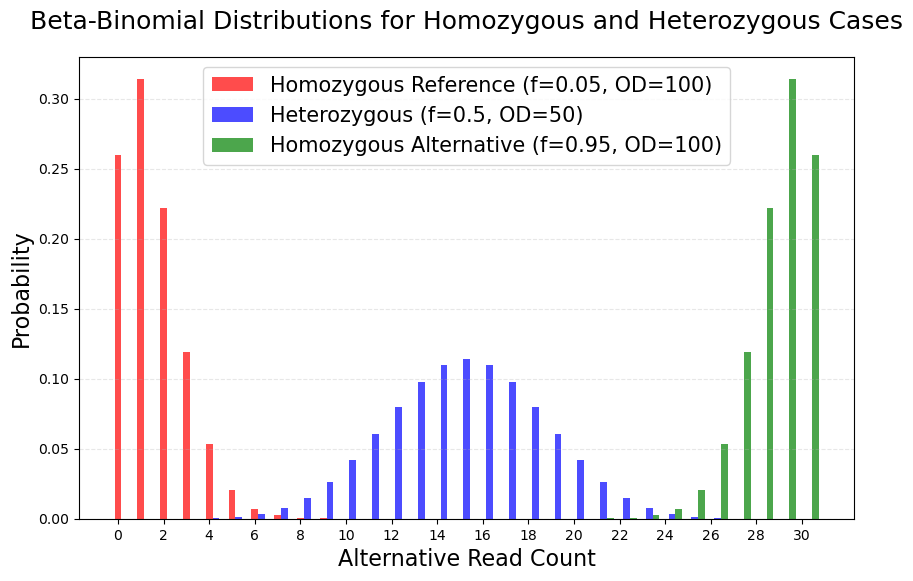

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import betabinom

# Parameters
n = 30  # Total read counts
overdispersion_values = {'Heterozygous': 50, 'Homozygous': 100}
frequencies = {'Homozygous Reference': 0.05, 'Heterozygous': 0.5, 'Homozygous Alternative': 0.95}

# Function to calculate alpha and beta from f and overdispersion
def get_alpha_beta(f, overdispersion):
    alpha = f * overdispersion
    beta = (1 - f) * overdispersion
    return alpha, beta

# Plotting
plt.figure(figsize=(10, 6))
colors = {'Homozygous Reference': 'red', 'Heterozygous': 'blue', 'Homozygous Alternative': 'green'}
bar_width = 0.3  # Width of each bar

for idx, (case, f) in enumerate(frequencies.items()):
    # Determine overdispersion based on the case
    overdispersion = overdispersion_values['Heterozygous'] if case == 'Heterozygous' else overdispersion_values['Homozygous']
    
    # Calculate alpha and beta
    alpha, beta = get_alpha_beta(f, overdispersion)
    
    # Beta-Binomial PMF
    x = np.arange(0, n + 1)  # Possible counts
    pmf = betabinom.pmf(x, n, alpha, beta)
    
    # Offset bars for visibility
    plt.bar(x + idx * bar_width, pmf, bar_width, label=f"{case} (f={f}, OD={overdispersion})", color=colors[case], alpha=0.7)

# Add legend and labels
plt.legend(fontsize=15)
plt.xlabel("Alternative Read Count", fontsize=16)
plt.ylabel("Probability", fontsize=16)
plt.title("Beta-Binomial Distributions for Homozygous and Heterozygous Cases", fontsize=18, pad=20)
plt.xticks(np.arange(0, n + 1, 2))  # Set x-ticks
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Show plot
plt.show()